In [1]:
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

2024-06-19 16:08:15.414972: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 16:08:15.461075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 16:08:16.113838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
y_train = pd.read_csv('../Dataset_MovieSummaries/y_train1.csv')
y_train.drop('Unnamed: 0', axis=1, inplace=True)
x_train = pd.read_csv('../Dataset_MovieSummaries/X_train1.csv')
x_train.drop('Unnamed: 0', axis=1, inplace=True)
y_test = pd.read_csv('../Dataset_MovieSummaries/y_test1.csv')
y_test.drop('Unnamed: 0', axis=1, inplace=True)
x_test = pd.read_csv('../Dataset_MovieSummaries/X_test1.csv')
x_test.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [4]:
x_train.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
x_val.reset_index(drop = True, inplace = True)
y_val.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization, Activation
from keras.initializers import glorot_uniform
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.regularizers import l2
import math

def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=10):
    def schedule(epoch):
        return max(initial_lr * math.pow(decay_factor, math.floor((1+epoch)/step_size)), 0.000001)
    return LearningRateScheduler(schedule)
    
learning_rate = 0.0001  # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
# Define the model
model = Sequential()
model.add(Dense(512, input_shape=(x_train.shape[1],), kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512, kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128, kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer=glorot_uniform(),kernel_regularizer=l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Output layer with softmax activation for multiclass classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()


/home/asolta2s/myenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_59 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 854,732 (3.26 MB)

 Trainable params: 852,300 (3.25 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
batch_size = 128
epochs = 200
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                   shuffle=True,
                   callbacks=[step_decay_schedule(initial_lr=0.0005, decay_factor=0.7, step_size=10),early_stopping ])

Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0758 - loss: 109.7114 - val_accuracy: 0.0546 - val_loss: 34.8234 - learning_rate: 5.0000e-04
Epoch 2/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0753 - loss: 25.3946 - val_accuracy: 0.0546 - val_loss: 8.6774 - learning_rate: 5.0000e-04
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1240 - loss: 6.6890 - val_accuracy: 0.1269 - val_loss: 3.1294 - learning_rate: 5.0000e-04
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2176 - loss: 2.5317 - val_accuracy: 0.1269 - val_loss: 1.6314 - learning_rate: 5.0000e-04
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2394 - loss: 1.3506 - val_accuracy: 0.1269 - val_loss: 1.1167 - learning_rate: 5.0000e-04
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2703 - loss: 0.9285 - val_accuracy: 0.1269 - val_loss: 0.8962 - learning_rate: 5.0000e-04
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accura

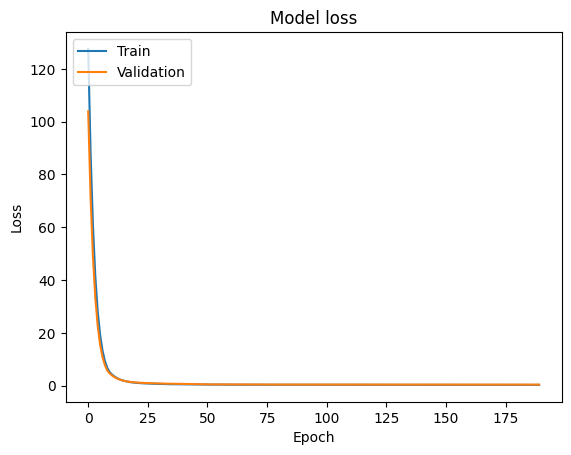

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [77]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3441 - loss: 0.4136
Test Accuracy: 33.97%


In [78]:
from sklearn.metrics import accuracy_score, classification_report
# Predict and evaluate the model
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred_binary, target_names=list(y_train.columns))
print(report)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.26
                  precision    recall  f1-score   support

          Action       0.70      0.54      0.61       581
Action/Adventure       0.69      0.53      0.60       576
       Adventure       0.74      0.47      0.58       533
          Comedy       0.69      0.33      0.45       646
   Crime Fiction       0.68      0.40      0.50       421
           Drama       0.71      0.60      0.65       970
     Family Film       0.75      0.61      0.67       479
          Horror       0.80      0.71      0.75       589
    Romance Film       0.71      0.60      0.65       460
  Romantic drama       0.74      0.63      0.68       408
      Short Film       0.81      0.69      0.75       584
        Thriller       0.61      0.43      0.50       536

       micro avg       0.72      0.55      0.62      6783
       macro avg       0.72      0.54      0.62      6783
    weighted avg       0.72      0.55      0.62      6783
     samples avg

/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
model.save('model1.keras')


In [ ]:
epochs = 200
early stopping 


In [11]:
y_pred_binary

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [13]:
y_test.iloc[0]

Action              0
Action/Adventure    0
Adventure           0
Black-and-white     1
Comedy              0
Crime Fiction       0
Drama               0
Family Film         0
Horror              0
Indie               0
Romance Film        0
Short Film          0
Thriller            1
World cinema        0
Name: 0, dtype: int64

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [18]:
from sklearn.metrics import accuracy_score, classification_report
y_pred_binary = (y_pred >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred_binary, target_names=list(y_train.columns))
print(report)

Accuracy: 0.17
                  precision    recall  f1-score   support

          Action       0.72      0.42      0.53       581
Action/Adventure       0.68      0.38      0.48       576
       Adventure       0.73      0.34      0.47       533
          Comedy       0.62      0.24      0.35       646
   Crime Fiction       0.67      0.31      0.43       421
           Drama       0.70      0.55      0.62       970
     Family Film       0.80      0.44      0.57       479
          Horror       0.83      0.53      0.65       589
    Romance Film       0.77      0.39      0.52       460
  Romantic drama       0.81      0.43      0.56       408
      Short Film       0.88      0.59      0.70       584
        Thriller       0.62      0.30      0.40       536

       micro avg       0.74      0.42      0.54      6783
       macro avg       0.74      0.41      0.52      6783
    weighted avg       0.73      0.42      0.53      6783
     samples avg       0.58      0.44      0.47      67

/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [153]:
import lightgbm as lgb
early_stopping_callback = lgb.early_stopping(stopping_rounds=10)
def train_and_predict(X_train, X_test, y_train, y_test):
    predictions = np.zeros_like(y_test)
    for i, label in enumerate(y_train.columns):
        print(f'Training model for label: {label}')
        lgb_train = lgb.Dataset(X_train, y_train.iloc[:, i])
        lgb_eval = lgb.Dataset(X_test, y_test.iloc[:, i], reference=lgb_train)

        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9
        }

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=100,
                        valid_sets=lgb_eval,
                        callbacks=[early_stopping_callback])

        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        predictions[:, i] = (y_pred > 0.5).astype(int)
    return predictions

# Train the model and get predictions
y_pred = train_and_predict(x_train, x_test, y_train, y_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=list(y_train.columns))
print(report)

Training model for label: Action
[LightGBM] [Info] Number of positive: 1902, number of negative: 7066


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f9c7c0c8b80>
Traceback (most recent call last):
  File "/home/asolta2s/myenv/lib64/python3.9/site-packages/lightgbm/basic.py", line 255, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Auto-choosing col-wise multi-threading, the overhead of testing was 2.193947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 149772
[LightGBM] [Info] Number of data points in the train set: 8968, number of used features: 1000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212087 -> initscore=-1.312389
[LightGBM] [Info] Start training from score -1.312389


KeyboardInterrupt: 

In [20]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Detailed classification report
report = classification_report(y_test, y_pred, target_names=list(y_train.columns))
print(report)

Accuracy: 0.13
                  precision    recall  f1-score   support

          Action       0.79      0.42      0.55       636
Action/Adventure       0.72      0.37      0.49       599
       Adventure       0.78      0.36      0.50       546
 Black-and-white       0.86      0.20      0.32       455
          Comedy       0.75      0.27      0.40       728
   Crime Fiction       0.81      0.37      0.51       435
           Drama       0.69      0.45      0.55       986
     Family Film       0.82      0.42      0.56       444
          Horror       0.86      0.56      0.68       596
           Indie       0.84      0.07      0.13       454
    Romance Film       0.67      0.28      0.40       364
      Short Film       0.87      0.54      0.67       582
        Thriller       0.77      0.34      0.47       583
    World cinema       0.81      0.12      0.21       423

       micro avg       0.78      0.36      0.49      7831
       macro avg       0.79      0.34      0.46      78

/home/asolta2s/myenv/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
